In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ReinfLayer, EC2ConcreteMatMod, EC2PlateauConcreteMatMod
from bmcs_beam.api import FourPBSystem, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign
import numpy as np
import pandas as pd
import bmcs_utils.api as bu
import matplotlib.pyplot as plt

In [2]:
# Concrete C3-HF2-165-4
E_cm_C3 = 44049.8
f_cm_C3 = 96.96
fctm_sp = 4.89
fctm_fl = 11.62

In [3]:
# solidian GRID Q95-CCE-38-E5 (according to performed tensile tests)
f_t_mat = 3823.9
E_f_mat = 246525.28

In [4]:
def get_dp(f_cm = f_cm_C3, E_cm = E_cm_C3, fctm_fl=None,
           setup='4pb', L=1800, L_F=None,
           high_kappa = 0.00018, concrete_law='EC2',
           B=200, H=150, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=None,
           grid_layers_spacing=[], grid_layers_area=[]):
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa, n_kappa=400)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    if fctm_fl is None:
        fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
    if concrete_law == 'EC2 with plateau' or concrete_law == 'EC2':
        mc.cs_design.matrix_.trait_set(f_cm = f_cm)
    elif concrete_law == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
            eps_cy=EC2.get_eps_c3(f_ck),
            eps_cu=EC2.get_eps_cu3(f_ck),
        )
    
    mc.cs_design.matrix_.trait_set(E_cc=E_cm, 
                                   E_ct=E_cm, 
                                   eps_cr = fctm_fl/E_cm, 
                                   eps_tu = fctm_fl/E_cm,)

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    # Carbon properties
    E_nm=E_f_mat if E_nm is None else E_nm
    f_t=f_t_mat if f_t is None else f_t
    spacing = 38
    rov_num = int(B/spacing) + 1
    rov_cs_area = 3.62
    if A is None:
        A = rov_num * rov_cs_area
    if z is None:
        z = 10
        
    d = H - z
    
    grid_layers_n = len(grid_layers_area) if grid_layers_area else 1
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name='grid', z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                bl1 = ReinfLayer(name='grid ' + str(i+1), 
                                 z=grid_layers_spacing[i] if grid_layers_spacing else 10, 
                                 A=grid_layers_area[i] if grid_layers_area else A, 
                                 matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        mc.cross_section_layout.add_layer(bl1)

    rho = A/(B*d)
    print('A=', A)
    print(r'rho =', round(rho * 100, 2), r'%')
    # mechanical reinforcement ratio
#     w_m = A * f_t / (B * H * f_cm)
#     print('w_m:', w_m)

    dp = DeflectionProfile(mc=mc)
    
    if setup == '4pb':
        dp.beam_design.system = '4pb'
        if L_F is not None:
            print('L_F assigned!')
            dp.beam_design.system_.L_F = L_F
    elif setup == '3pb':
        dp.beam_design.system = '3pb'
    elif setup == 'dist':
        dp.beam_design.system = 'simple_beam_dist_load'
        
    dp.beam_design.system_.L = L
    
    print('l/d =', dp.beam_design.system_.L/d)
    
    return dp

In [5]:
def get_exp_data(test_num=1):
    skiprows = 3
    delimiter=';'
    decimal=','
    file_path = './results/T' + str(test_num) + '.csv'
    headers_array = list(np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, nrows=1, header=None))[0])
    
    time_idx = 0
    force_idx = headers_array.index('Kraft')
    weg_idx = headers_array.index('Weg')
    IWA_M_hinten_idx = headers_array.index('IWA_M_hinten')
    IWA_M_vorne_idx = headers_array.index('IWA_M_vorne')
    DMS_idx = headers_array.index('DMS-1')
    
    data = np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, skiprows=skiprows))
    time = data[:, 0]
    force = -data[:, force_idx]
    dms = -data[:, DMS_idx]
    weg = -data[:, weg_idx]
    hinten_vorne = - data[:, (IWA_M_hinten_idx, IWA_M_vorne_idx)]
    avg_hinten_vorne = (hinten_vorne[:, 0] + hinten_vorne[:, 1])/2
    
    return time, force, weg, avg_hinten_vorne, dms, hinten_vorne

def get_exp_fw(test_num=1):
    _, force, _, avg_hinten_vorne, _, hinten_vorne = get_exp_data(test_num = test_num)
    if test_num == 7:
        avg_hinten_vorne = hinten_vorne[:, 0]
    elif test_num == 8:
        avg_hinten_vorne = hinten_vorne[:, 1]
    return force, avg_hinten_vorne

In [6]:
bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

def plot_fw_ver(ver_data, test_name='', dp=None, title=None, ax=None, color_i=0): # ax, dp, ver_data
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4.7))
    if dp:
        dp.plot_fw(ax, dashed=True, color=plot_colors[color_i], label=  test_name + ' (Sim.)', lw=1.5)
    ax.plot(ver_data[1], ver_data[0], c=plot_colors[color_i], label=  test_name + ' (Exp.)', lw=1.25)
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Midspan deflection [mm]')
    ax.set_ylabel('Load [kN]')
    ax.legend()
#     ax.grid()
    if 'fig' in locals():
        return fig, ax

In [7]:
# M1 concrete mix (average of M1 + M2 in the excel table)
M1_f_cm = 98.63
M1_E_cm = 45306.54
M1_f_ctm = 5.11
M1_concrete = dict(f_cm= M1_f_cm, E_cm = M1_E_cm, fctm_fl=M1_f_ctm)

# M2 concrete mix (average of M3 + M4 in the excel table)
M2_f_cm = 95.3
M2_E_cm = 42793.1
M2_f_ctm = 4.67
M2_concrete = dict(f_cm= M2_f_cm, E_cm = M2_E_cm, fctm_fl=M2_f_ctm)

## T1_4PB_C_1, T2_4PB_C_1

In [8]:
# Using T1 exact dimensions
dp1_2 = get_dp(high_kappa =0.0003, B=303, H=99, setup='4pb', reinf = 'carbon', **M1_concrete)
# dp1_2.interact()

A= 28.96
rho = 0.11 %
l/d = 20.224719101123597


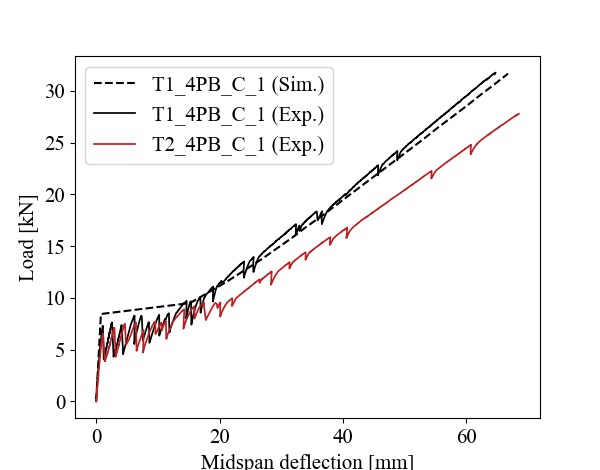

In [12]:
fig, ax = plot_fw_ver([*get_exp_fw(1)], r'T1_4PB_C_1', dp=dp1_2, color_i=0)
plot_fw_ver([*get_exp_fw(2)], r'T2_4PB_C_1', ax=ax, color_i=1)
# fig.savefig('T1_T2_ld_exp_vs_sim.pdf')
# fig

## T3_4PB_C_1.5, T4_4PB_C_1.5

In [13]:
# Using T3 exact dimensions
dp3_4 = get_dp(high_kappa =0.00025, B=303, H=98, setup='4pb', 
            reinf = 'carbon', 
            **M1_concrete,
            grid_layers_spacing=[10, 20],
            grid_layers_area = [8 * 3.62, 4 * 3.62]
            )
# dp3_4.interact()

A= 57.92
rho = 0.22 %
l/d = 20.454545454545453


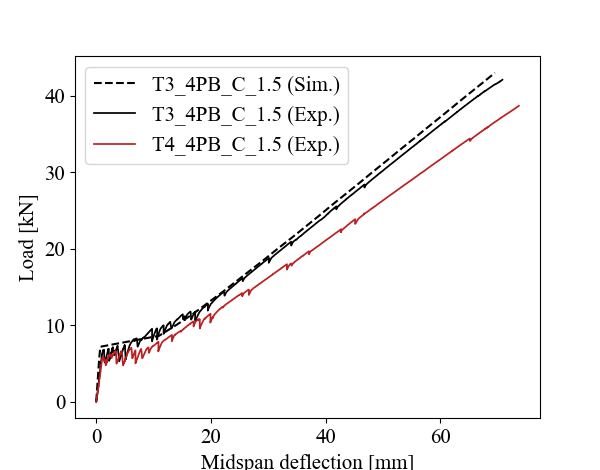

In [16]:
fig, ax = plot_fw_ver([*get_exp_fw(3)], r'T3_4PB_C_1.5', dp=dp3_4, color_i=0)
plot_fw_ver([*get_exp_fw(4)], r'T4_4PB_C_1.5', ax=ax, color_i=1)
# fig.savefig('T3_T4_ld_exp_vs_sim.pdf')
# fig

## T5_4PB_C_3

In [17]:
dp5 = get_dp(high_kappa =0.0003, B=201, H=80, setup='4pb', 
            reinf = 'carbon', 
            **M1_concrete,
            grid_layers_spacing=[10, 15, 20],
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )
# dp5.interact()

A= 65.16
rho = 0.46 %
l/d = 25.714285714285715


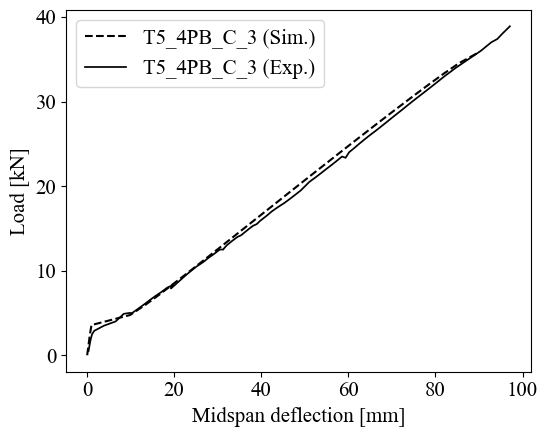

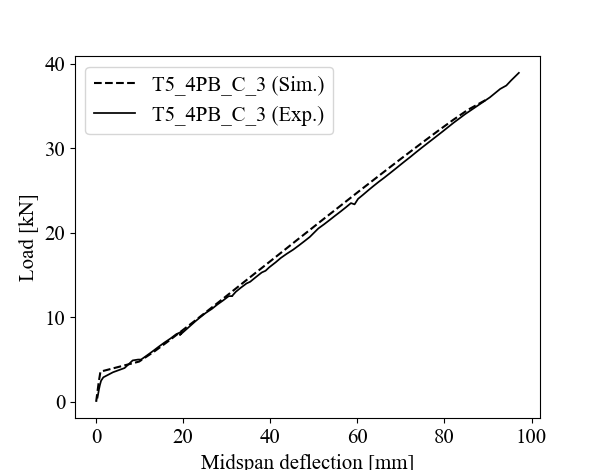

In [18]:
fig, ax = plot_fw_ver([*get_exp_fw(5)], r'T5_4PB_C_3', dp=dp5, color_i=0)
fig

## T6_4PB_C_3

In [19]:
dp6 = get_dp(high_kappa =0.0003, B=204, H=79, setup='4pb', 
            reinf = 'carbon',
            **M1_concrete,
            grid_layers_spacing=[10, 15, 20],
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )
# dp6.interact()

A= 65.16
rho = 0.46 %
l/d = 26.08695652173913


In [20]:
plot_fw_ver([*get_exp_fw(6)], r'T6_4PB_C_3', dp=dp6, ax=ax, color_i=1)
# fig

## T7_4PB_C_3

In [21]:
dp7 = get_dp(high_kappa =0.0003, B=204, H=81, setup='4pb', 
            reinf = 'carbon',
            **M2_concrete,
            grid_layers_spacing=[10, 15, 20],
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )
# dp7.interact()

A= 65.16
rho = 0.45 %
l/d = 25.35211267605634


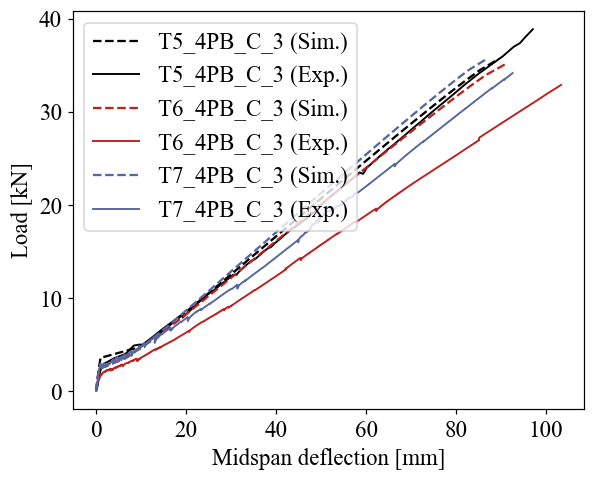

In [22]:
plot_fw_ver([*get_exp_fw(7)], r'T7_4PB_C_3', dp=dp7, ax=ax, color_i=2)
# fig.savefig('T5_T6_T7_ld_exp_vs_sim.pdf')
fig

## T8_3PB_C_1

In [24]:
dp8 = get_dp(high_kappa =0.00023, B=300, H=100, setup='3pb', 
            reinf = 'carbon', 
            **M2_concrete,
            )
# dp8.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


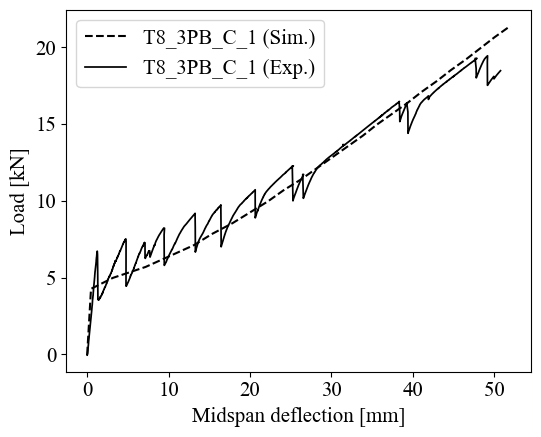

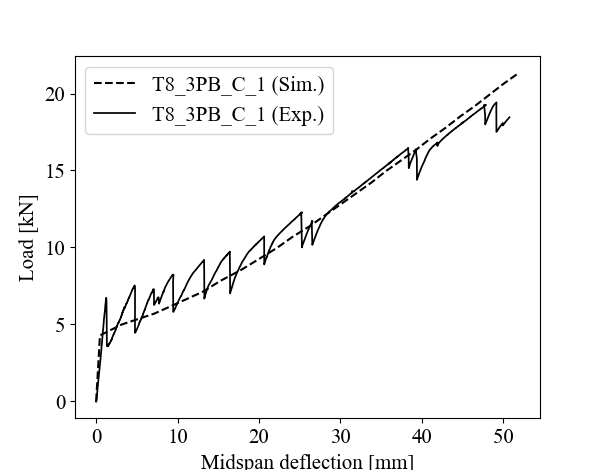

In [25]:
fig, ax = plot_fw_ver([*get_exp_fw(8)], r'T8_3PB_C_1', dp=dp8, color_i=0)
fig

## T9_3PB_C_1

In [26]:
dp9 = get_dp(high_kappa =0.00023, B=301, H=100, setup='3pb', 
            reinf = 'carbon', 
            **M2_concrete,
            )
# dp9.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


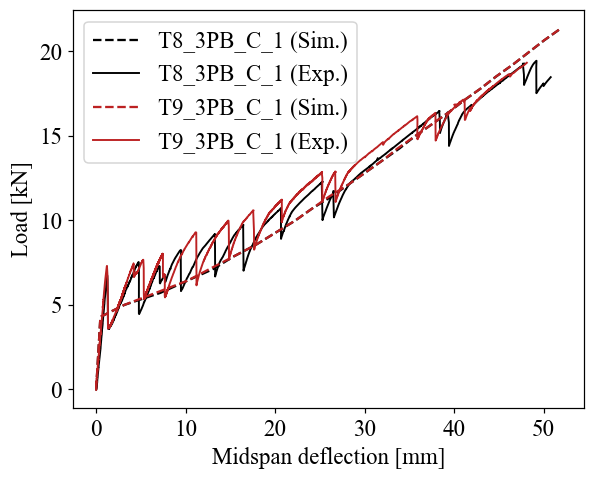

In [27]:
plot_fw_ver([*get_exp_fw(9)], r'T9_3PB_C_1', dp=dp9, ax=ax, color_i=1)
# fig.savefig('T8_T9_ld_exp_vs_sim.pdf')
fig

## T10_4PB_CS_0.5

In [29]:
dp10 = get_dp(high_kappa =0.00025, B=303, H=100, setup='4pb', 
            reinf = 'carbon',
            A=4*3.62,
            z=20,
            **M2_concrete,
            )

steel_layer = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp10.mc.cross_section_layout.add_layer(steel_layer)

# dp10.interact()

A= 14.48
rho = 0.06 %
l/d = 22.5


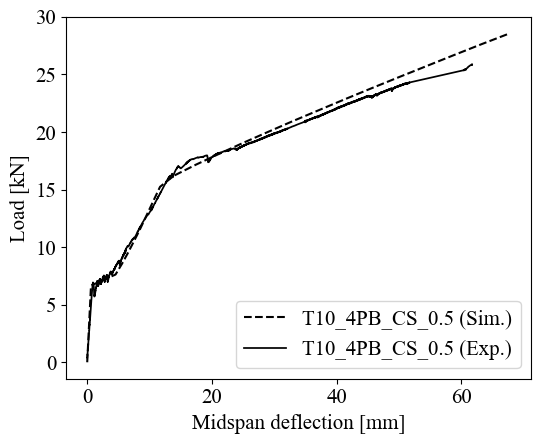

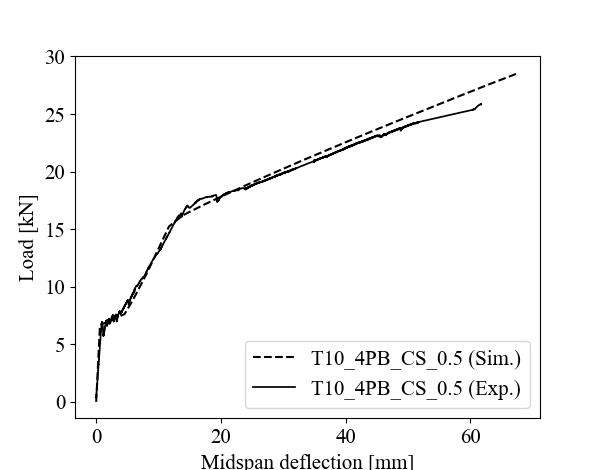

In [30]:
fig, ax = plot_fw_ver([*get_exp_fw(10)], r'T10_4PB_CS_0.5', dp=dp10, color_i=0)
fig

## T11_4PB_CS_0.5

In [31]:
dp11 = get_dp(high_kappa =0.00025, B=305, H=101, setup='4pb', 
            reinf = 'carbon',
            A=4*3.62,
            z=20,
            **M2_concrete,
            )

steel_layer = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp11.mc.cross_section_layout.add_layer(steel_layer)

# dp11.interact()

A= 14.48
rho = 0.06 %
l/d = 22.22222222222222


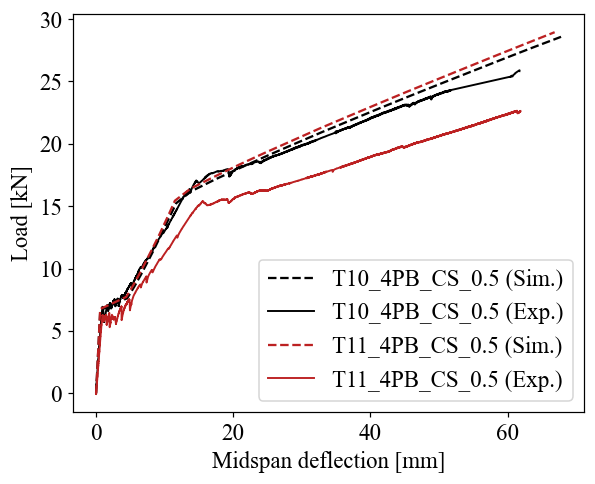

In [32]:
plot_fw_ver([*get_exp_fw(11)], r'T11_4PB_CS_0.5', dp=dp11, ax=ax, color_i=1)
# fig.savefig('T10_T11_ld_exp_vs_sim.pdf')
fig

## T12_4PB_S, T13_4PB_S
Note: Combined because using the exact cross-section dimensions didn't give any noticeable difference in the behaviour

In [34]:
dp12_13 = get_dp(high_kappa =0.00062, B=300, H=100, setup='4pb', 
            reinf = 'steel', 
            A=4 * np.pi * (4**2), 
            z=14,
            **M2_concrete,
            )

# B500 reinf:
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.eps_ud = 0.05
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.f_sy = 550
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.f_st = 578

# dp12_13.interact()

A= 201.06192982974676
rho = 0.78 %
l/d = 20.930232558139537


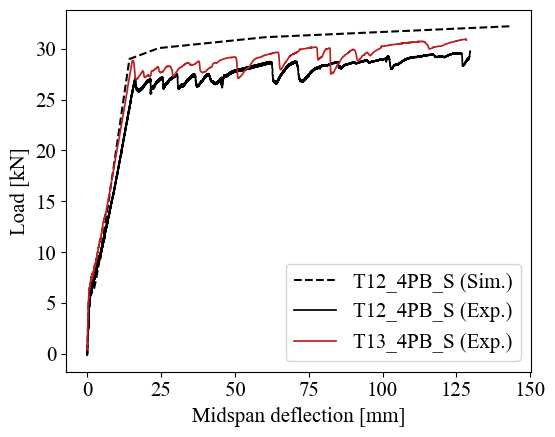

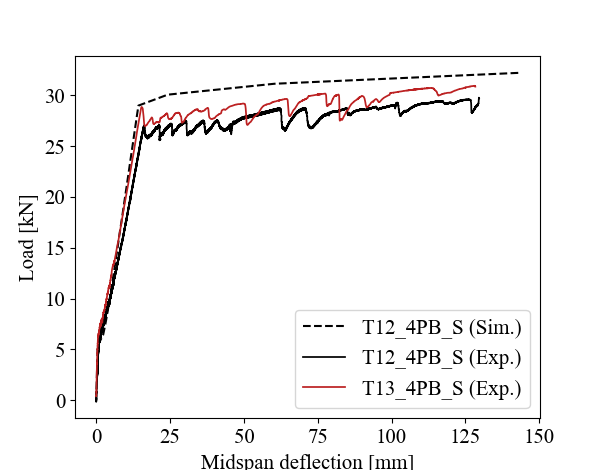

In [35]:
fig, ax = plot_fw_ver([*get_exp_fw(12)], r'T12_4PB_S', dp=dp12_13, color_i=0)
plot_fw_ver([*get_exp_fw(13)], r'T13_4PB_S', ax=ax, color_i=1)
# fig.savefig('T12_T13_ld_exp_vs_sim.pdf')
fig